In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")


✓ Libraries imported


In [16]:
# Load training data
train_df = pd.read_csv('../data/newtrain.csv')

print(f"Training data shape: {train_df.shape}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nFirst few rows:")
train_df.head()


Training data shape: (75000, 7)

Columns: ['sample_id', 'item_name', 'value', 'unit', 'bullet_points', 'image_link', 'price']

First few rows:


,sample_id,item_name,value,unit,bullet_points,image_link,price
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",72.00,Fl Oz,NaN,https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",32.00,Ounce,Original Butter Cookies: Classic butter cookie...,https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",11.40,Ounce,Loaded with hearty long grain wild rice and ve...,https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,11.25,Ounce,"Add to your favorite appetizers, dips & spread...",https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",12.00,Count,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [17]:
# Basic info
print("=== DATA INFO ===")
print(train_df.info())

print("\n=== MISSING VALUES ===")
print(train_df.isnull().sum())

print("\n=== BASIC STATISTICS ===")
print(train_df.describe())


=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      75000 non-null  int64  
 1   item_name      74992 non-null  object 
 2   value          74060 non-null  float64
 3   unit           74059 non-null  object 
 4   bullet_points  60643 non-null  object 
 5   image_link     75000 non-null  object 
 6   price          75000 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 4.0+ MB
None

=== MISSING VALUES ===
sample_id            0
item_name            8
value              940
unit               941
bullet_points    14357
image_link           0
price                0
dtype: int64

=== BASIC STATISTICS ===
           sample_id         value         price
count   75000.000000  74060.000000  75000.000000
mean   149841.917707     54.306073     23.647654
std     86585.346513    461.818743     3

=== PRICE STATISTICS ===
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


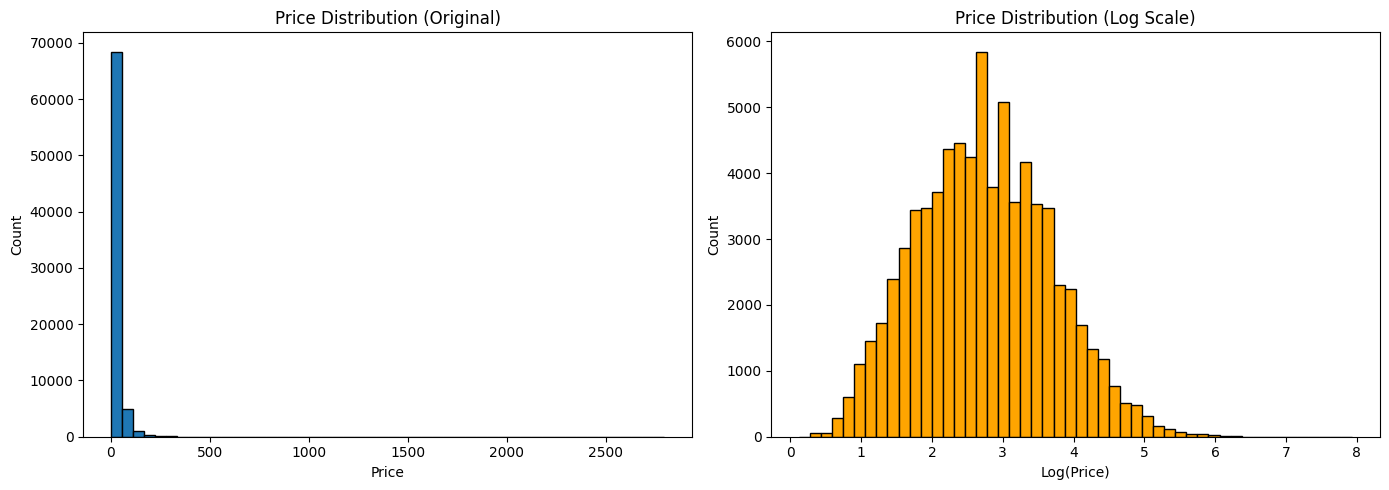


Price range: $0.13 to $2796.00
Median price: $14.00


In [18]:
# Analyze price distribution
print("=== PRICE STATISTICS ===")
print(train_df['price'].describe())

# Plot price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original price distribution
axes[0].hist(train_df['price'], bins=50, edgecolor='black')
axes[0].set_title('Price Distribution (Original)')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')

# Log-transformed price (to see distribution better)
axes[1].hist(np.log1p(train_df['price']), bins=50, edgecolor='black', color='orange')
axes[1].set_title('Price Distribution (Log Scale)')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nPrice range: ${train_df['price'].min():.2f} to ${train_df['price'].max():.2f}")
print(f"Median price: ${train_df['price'].median():.2f}")


In [21]:
# Check if you have Item_name, Bullet_points, value, unit columns
print("=== CHECKING FOR STRUCTURED COLUMNS ===")

structured_cols = ['Item_name', 'Bullet_points', 'value', 'unit']
for col in structured_cols:
    if col in train_df.columns:
        print(f"✓ {col} column EXISTS")
        print(f"  Sample: {train_df[col].iloc[0][:100] if len(str(train_df[col].iloc[0])) > 100 else train_df[col].iloc[0]}")
        print()
    else:
        print(f"✗ {col} column MISSING")


=== CHECKING FOR STRUCTURED COLUMNS ===
✗ Item_name column MISSING
✗ Bullet_points column MISSING
✓ value column EXISTS
  Sample: 72.0

✓ unit column EXISTS
  Sample: Fl Oz



In [22]:
train_df[train_df['sample_id'] == 186165]

,sample_id,item_name,value,unit,bullet_points,image_link,price
48,186165,Seasons Brand Imported Skinless & Boneless Sar...,NaN,NaN,NaN,https://m.media-amazon.com/images/I/41HJmvLaTy...,2.54


In [53]:
""" import re

print("=== EXTRACTING HIDDEN QUANTITY FROM ITEM NAMES ===\n")

# Function to extract quantity from text
def extract_quantity_from_text(text):
    Extract number + unit patterns from text
    if pd.isna(text) or text == '':
        return None, None
    
    text = str(text).lower()
    
    patterns = [
        r'(\d+\.?\d*)\s*(oz|ounce|lb|pound|kg|g|gram|l|liter|ml|gallon|fl oz)',
        r'(?:pack|set|box)\s+of\s+(\d+)',
        r'(\d+)[-\s]?(count|pack|piece|pcs)',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            if len(match.groups()) == 2:
                return float(match.group(1)), match.group(2)
            elif 'pack of' in pattern or 'set of' in pattern:
                return float(match.group(1)), 'count'
    return None, None

# CHANGE HERE: Use train_df instead of train_clean
missing_mask = train_df['value'].isna() | train_df['unit'].isna()
missing_count = missing_mask.sum()

print(f"Rows with missing value/unit: {missing_count}")

# Extract from item_name for missing rows
extracted_count = 0
for idx in train_df[missing_mask].index:
    item_name = train_df.loc[idx, 'item_name']
    extracted_value, extracted_unit = extract_quantity_from_text(item_name)
    
    if extracted_value is not None:
        train_df.loc[idx, 'value'] = extracted_value
        train_df.loc[idx, 'unit'] = extracted_unit
        extracted_count += 1

print(f"✓ Successfully extracted: {extracted_count}/{missing_count}")
print(f"✗ Still missing: {missing_count - extracted_count}")

# Fill remaining with 0/unknown
train_df['value'] = train_df['value'].fillna(0)
train_df['unit'] = train_df['unit'].fillna('unknown')

print("\n✓ Extraction complete!") """


import re

print("=== ENHANCED QUANTITY EXTRACTION ===\n")

def extract_quantity_from_text_enhanced(text):
    """
    Enhanced extraction covering all 95 unit variations
    Returns: (value, standardized_unit) or (None, None)
    """
    if pd.isna(text) or text == '':
        return None, None
    
    text = str(text).lower()
    
    # Comprehensive patterns
    patterns = [
        # Weight units (ounce variations)
        (r'(\d+\.?\d*)\s*(?:oz|ounce|ounces|oz\.)', 'ounce'),
        
        # Fluid ounce variations
        (r'(\d+\.?\d*)\s*(?:fl\s*oz|fl\.?\s*oz|fluid\s+ounce|fluid\s+ounces|floz)', 'fluid_ounce'),
        
        # Pound variations
        (r'(\d+\.?\d*)\s*(?:lb|lbs|pound|pounds)', 'pound'),
        
        # Gram variations
        (r'(\d+\.?\d*)\s*(?:g|gram|grams|gramm|gr)(?:\s|$|,)', 'gram'),
        
        # Kilogram variations
        (r'(\d+\.?\d*)\s*(?:kg|kilogram|kilograms|k)(?:\s|$|,)', 'kilogram'),
        
        # Milligram
        (r'(\d+\.?\d*)\s*(?:mg|milligram|milligrams)', 'milligram'),
        
        # Liter variations
        (r'(\d+\.?\d*)\s*(?:l|ltr|liter|liters|litre|litres)(?:\s|$|,)', 'liter'),
        
        # Milliliter variations
        (r'(\d+\.?\d*)\s*(?:ml|milliliter|millilitre|mililitro)', 'milliliter'),
        
        # Gallon
        (r'(\d+\.?\d*)\s*(?:gal|gallon|gallons)', 'gallon'),
        
        # Count variations - specific patterns first
        (r'(\d+)\s*(?:count|ct|pc|pcs|piece|pieces)', 'count'),
        (r'(\d+)[-\s](?:count|pack|piece)', 'count'),
        
        # Pack of / Set of / Box of
        (r'(?:pack|set|box)\s+of\s+(\d+)', 'count'),
        (r'(\d+)[-\s](?:pack|packs)', 'count'),
        
        # Container types (treat as count)
        (r'(\d+\.?\d*)\s*(?:bag|bags|bottle|bottles|can|cans|jar|jars|pouch|pouches)', 'count'),
        (r'(\d+\.?\d*)\s*(?:box|boxes|carton|cartons|bucket|buckets)', 'count'),
        
        # Area (rare)
        (r'(\d+\.?\d*)\s*(?:sq\s*ft|foot|feet)', 'count'),
    ]
    
    for pattern, unit in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            try:
                value = float(match.group(1))
                return value, unit
            except (ValueError, IndexError):
                continue
    
    return None, None


# Test on sample products
print("=== TESTING ENHANCED EXTRACTION ===\n")

test_items = [
    "Product 12 Fl Oz",
    "Item 1.5 kg",
    "Thing 500ml",
    "Pack of 12",
    "24-Count Box",
    "10g Sample",
    "16.5 ounces",
    "2 liter bottle",
    "Himalania Pink Salt Fine Jar 10.0 OZ(Pack of 6)",
]

for item in test_items:
    val, unit = extract_quantity_from_text_enhanced(item)
    print(f"{item:50s} → value={val}, unit={unit}")


=== ENHANCED QUANTITY EXTRACTION ===

=== TESTING ENHANCED EXTRACTION ===

Product 12 Fl Oz                                   → value=12.0, unit=fluid_ounce
Item 1.5 kg                                        → value=1.5, unit=kilogram
Thing 500ml                                        → value=500.0, unit=milliliter
Pack of 12                                         → value=12.0, unit=count
24-Count Box                                       → value=24.0, unit=count
10g Sample                                         → value=10.0, unit=gram
16.5 ounces                                        → value=16.5, unit=ounce
2 liter bottle                                     → value=2.0, unit=liter
Himalania Pink Salt Fine Jar 10.0 OZ(Pack of 6)    → value=10.0, unit=ounce


In [49]:
train_df.head()


,sample_id,item_name,value,unit,bullet_points,image_link,price,unit_standardized,quantity_value,unit_multiplier,quantity_normalized,quantity_log,quantity_sqrt,has_quantity
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",72.00,Fl Oz,,https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,fluid_ounce,72.00,29.5735,2129.292000,7.664014,46.144252,1
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",32.00,Ounce,Original Butter Cookies: Classic butter cookie...,https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,ounce,32.00,28.3495,907.184000,6.811447,30.119495,1
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",11.40,Ounce,Loaded with hearty long grain wild rice and ve...,https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,ounce,11.40,28.3495,323.184300,5.781312,17.977327,1
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,11.25,Ounce,"Add to your favorite appetizers, dips & spread...",https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,ounce,11.25,28.3495,318.931875,5.768108,17.858664,1
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",12.00,Count,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,count,12.00,1.0000,12.000000,2.564949,3.464102,1


In [54]:
print("=== ANALYZING REMAINING MISSING QUANTITIES ===\n")

# Find rows that still have missing/zero values
still_missing = train_df[(train_df['value'] == 0) | (train_df['unit'] == 'unknown')]

print(f"Products still without quantity: {len(still_missing)}")
print(f"Percentage: {len(still_missing)/len(train_df)*100:.2f}%\n")

# Look at examples
print("=== SAMPLE PRODUCTS WITHOUT QUANTITY ===")
sample_missing = still_missing[['sample_id', 'item_name', 'value', 'unit', 'price']].head(10)
print(sample_missing)

# Price comparison
print("\n=== PRICE STATISTICS ===")
print(f"Products WITH quantity:")
print(f"  Count: {len(train_df[train_df['value'] > 0]):,}")
print(f"  Mean price: ${train_df[train_df['value'] > 0]['price'].mean():.2f}")
print(f"  Median price: ${train_df[train_df['value'] > 0]['price'].median():.2f}")

print(f"\nProducts WITHOUT quantity:")
print(f"  Count: {len(still_missing):,}")
print(f"  Mean price: ${still_missing['price'].mean():.2f}")
print(f"  Median price: ${still_missing['price'].median():.2f}")


=== ANALYZING REMAINING MISSING QUANTITIES ===

Products still without quantity: 465
Percentage: 0.62%

=== SAMPLE PRODUCTS WITHOUT QUANTITY ===
      sample_id                                          item_name  value  \
255      238772                       DYE INK PAD Stamperia Coffee    0.0   
299      231191  Starbucks By Nespresso Single Origin Columbia ...    0.0   
671       45478         Curious George Goes to a Chocolate Factory    0.0   
1032      48402                 Crown Prince Tuna Tongol Sprng Wtr    0.0   
1120      70033                                         Thai Basil    0.0   
1247     172898  San Giorgio Enriched Macaroni Product Medium S...    0.0   
1681      31216                                 Dole Fruit Parfait    0.0   
2056      64584  AROMEO 4 Blush Pink Roses | Fresh Cut | Preser...    0.0   
2131      87394                                       Miracle Rice    0.0   
2363     139699                         Hi Chew Grape (Pack of 16)    0.0   

       

In [26]:
import re

print("=== EXTRACTING AND SAVING MISSING QUANTITIES ===\n")

# Function to extract from text
def extract_quantity_from_text(text):
    """Extract number + unit from text"""
    if pd.isna(text) or text == '':
        return None, None
    
    text = str(text).lower()
    
    patterns = [
        r'(\d+\.?\d*)\s*(oz|ounce|ounces|lb|lbs|pound|pounds|kg|kilogram|kilograms|g|gram|grams|mg|milligram|l|liter|litre|ml|milliliter|gallon|gal|fl oz|fluid ounce)',
        r'(?:pack|set|box)\s+of\s+(\d+)',
        r'(\d+)[-\s]?(count|pack|piece|pcs|pc)',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            if len(match.groups()) == 2:
                return float(match.group(1)), match.group(2)
            elif 'pack of' in pattern or 'set of' in pattern:
                return float(match.group(1)), 'count'
    return None, None


# Find rows with missing value OR unit
missing_mask = train_df['value'].isna() | train_df['unit'].isna()
original_missing = missing_mask.sum()

print(f"Rows with missing value/unit: {original_missing}")
print("Extracting from item_name...\n")

# Extract and UPDATE the original columns
extracted_count = 0
for idx in train_df[missing_mask].index:
    item_name = train_df.loc[idx, 'item_name']
    extracted_value, extracted_unit = extract_quantity_from_text(item_name)
    
    if extracted_value is not None:
        # UPDATE original columns
        train_df.at[idx, 'value'] = extracted_value
        train_df.at[idx, 'unit'] = extracted_unit
        extracted_count += 1

print(f"✓ Successfully extracted and saved: {extracted_count}/{original_missing}")

# Check remaining missing
still_missing_value = train_df['value'].isna().sum()
still_missing_unit = train_df['unit'].isna().sum()

print(f"\n=== AFTER EXTRACTION ===")
print(f"Missing value: {still_missing_value}")
print(f"Missing unit: {still_missing_unit}")

# Fill remaining NaN with defaults
if still_missing_value > 0:
    train_df['value'] = train_df['value'].fillna(0.0)
    print(f"✓ Filled {still_missing_value} remaining missing values with 0.0")

if still_missing_unit > 0:
    train_df['unit'] = train_df['unit'].fillna('unknown')
    print(f"✓ Filled {still_missing_unit} remaining missing units with 'unknown'")

print("\n✓ Original value/unit columns updated!")


=== EXTRACTING AND SAVING MISSING QUANTITIES ===

Rows with missing value/unit: 0
Extracting from item_name...

✓ Successfully extracted and saved: 0/0

=== AFTER EXTRACTION ===
Missing value: 0
Missing unit: 0

✓ Original value/unit columns updated!


In [27]:
print("=== FINDING ZERO/UNKNOWN VALUES ===\n")

# Find rows with value = 0 OR unit = 'unknown'
zero_value_mask = (train_df['value'] == 0) | (train_df['value'] == 0.0)
unknown_unit_mask = (train_df['unit'] == 'unknown')

combined_mask = zero_value_mask | unknown_unit_mask

print(f"Rows with value = 0: {zero_value_mask.sum():,}")
print(f"Rows with unit = 'unknown': {unknown_unit_mask.sum():,}")
print(f"Combined (needing extraction): {combined_mask.sum():,}")

# Show samples
print("\n=== SAMPLE PRODUCTS WITH ZERO/UNKNOWN VALUES ===")
print(train_df[combined_mask][['sample_id', 'item_name', 'value', 'unit', 'price']].head(10))


=== FINDING ZERO/UNKNOWN VALUES ===

Rows with value = 0: 502
Rows with unit = 'unknown': 464
Combined (needing extraction): 503

=== SAMPLE PRODUCTS WITH ZERO/UNKNOWN VALUES ===
      sample_id                                          item_name  value  \
255      238772                       DYE INK PAD Stamperia Coffee    0.0   
299      231191  Starbucks By Nespresso Single Origin Columbia ...    0.0   
671       45478         Curious George Goes to a Chocolate Factory    0.0   
1032      48402                 Crown Prince Tuna Tongol Sprng Wtr    0.0   
1120      70033                                         Thai Basil    0.0   
1247     172898  San Giorgio Enriched Macaroni Product Medium S...    0.0   
1403     259068  Cooggies Cake & Muffin Bake Mix, Gluten Free, ...    0.0   
1681      31216                                 Dole Fruit Parfait    0.0   
1943      41932        OREGON CHAI MIX CHAI THE ORGNL, 8 PC PACK_6    0.0   
2056      64584  AROMEO 4 Blush Pink Roses | Fresh 

In [28]:
print("=== EXTRACTING QUANTITIES FOR ZERO VALUES ===\n")

# Find rows to extract
needs_extraction = (train_df['value'] == 0) | (train_df['unit'] == 'unknown')
total_to_extract = needs_extraction.sum()

print(f"Products needing extraction: {total_to_extract:,}")

if total_to_extract > 0:
    extracted_count = 0
    
    for idx in train_df[needs_extraction].index:
        item_name = train_df.loc[idx, 'item_name']
        extracted_value, extracted_unit = extract_quantity_from_text(item_name)
        
        if extracted_value is not None and extracted_value > 0:
            # Update original columns
            train_df.at[idx, 'value'] = extracted_value
            train_df.at[idx, 'unit'] = extracted_unit
            extracted_count += 1
    
    print(f"\n✓ Successfully extracted: {extracted_count}/{total_to_extract}")
    print(f"✗ Still zero/unknown: {total_to_extract - extracted_count}")
    
    # Show what was extracted
    print("\n=== EXAMPLES OF EXTRACTED VALUES ===")
    newly_filled = train_df[(train_df['value'] > 0) & needs_extraction]
    if len(newly_filled) > 0:
        print(newly_filled[['sample_id', 'item_name', 'value', 'unit', 'price']].head(10))
else:
    print("✓ All products already have quantity info!")


=== EXTRACTING QUANTITIES FOR ZERO VALUES ===

Products needing extraction: 503

✓ Successfully extracted: 38/503
✗ Still zero/unknown: 465

=== EXAMPLES OF EXTRACTED VALUES ===
       sample_id                                          item_name  value  \
1403      259068  Cooggies Cake & Muffin Bake Mix, Gluten Free, ...   16.0   
1943       41932        OREGON CHAI MIX CHAI THE ORGNL, 8 PC PACK_6    8.0   
2921       30645  Lucini, Extra Virgin Olive Oil Collection (Eve...  500.0   
5335      220816  Kidu Pantry Melting Chocolate Wafers Bulk In R...    1.0   
7207      276559  Lucini, Extra Virgin Olive Oil Collection (Pre...  500.0   
8149       64940  Family Party Pack Popular Popcorn Seasoning - ...    9.0   
10980     223834  KIDU Merckens Chocolate Melting Wafers 16 Ounc...   16.0   
12366      48624  Kitchen Of India Dinner - Spinach with Cottage...   10.0   
17940     129698  Arrowhead Sparkling Mountain Spring Water Can,...   12.0   
18030     127627  Kirkland Signature Shell

In [29]:
print("=== CURRENT DATA STATUS ===\n")

# Count by value
zero_values = (train_df['value'] == 0).sum()
has_values = (train_df['value'] > 0).sum()

print(f"Products with value > 0: {has_values:,} ({has_values/len(train_df)*100:.2f}%)")
print(f"Products with value = 0: {zero_values:,} ({zero_values/len(train_df)*100:.2f}%)")

# Count by unit
unknown_units = (train_df['unit'] == 'unknown').sum()
known_units = (train_df['unit'] != 'unknown').sum()

print(f"\nProducts with known unit: {known_units:,} ({known_units/len(train_df)*100:.2f}%)")
print(f"Products with unknown unit: {unknown_units:,} ({unknown_units/len(train_df)*100:.2f}%)")

# Value statistics
print(f"\n=== VALUE STATISTICS (excluding zeros) ===")
print(train_df[train_df['value'] > 0]['value'].describe())

# Unit distribution
print(f"\n=== TOP 15 UNITS ===")
print(train_df['unit'].value_counts().head(15))


=== CURRENT DATA STATUS ===

Products with value > 0: 74,536 (99.38%)
Products with value = 0: 464 (0.62%)

Products with known unit: 74,542 (99.39%)
Products with unknown unit: 458 (0.61%)

=== VALUE STATISTICS (excluding zeros) ===
count     74536.000000
mean         55.505593
std         589.768483
min           0.003500
25%           6.000000
50%          16.000000
75%          48.000000
max      100681.000000
Name: value, dtype: float64

=== TOP 15 UNITS ===
unit
Ounce      40980
Count      17431
Fl Oz      11084
ounce       2027
oz          1231
count        763
unknown      458
pound        178
fl oz        144
Oz            78
lb            61
ct            46
Pound         44
g             37
pack          31
Name: count, dtype: int64


In [30]:
print("=== ALL UNIQUE UNITS IN DATASET ===\n")

# Get all unique units
unique_units = train_df['unit'].unique()
print(f"Total unique unit values: {len(unique_units)}\n")

# Show all of them
print("Complete list of units:")
for i, unit in enumerate(sorted(unique_units), 1):
    count = (train_df['unit'] == unit).sum()
    print(f"{i:3d}. '{unit}' - {count:,} products")


=== ALL UNIQUE UNITS IN DATASET ===

Total unique unit values: 95

Complete list of units:
  1. '-' - 1 products
  2. '---' - 1 products
  3. '1' - 2 products
  4. '24' - 1 products
  5. '7' - 1 products
  6. '8' - 1 products
  7. 'BOX/12' - 1 products
  8. 'Bag' - 5 products
  9. 'Bottle' - 3 products
 10. 'Box' - 1 products
 11. 'Bucket' - 1 products
 12. 'COUNT' - 16 products
 13. 'CT' - 3 products
 14. 'Can' - 5 products
 15. 'Carton' - 1 products
 16. 'Count' - 17,431 products
 17. 'Each' - 7 products
 18. 'FL OZ' - 15 products
 19. 'FL Oz' - 28 products
 20. 'Fl Ounce' - 1 products
 21. 'Fl Oz' - 11,084 products
 22. 'Fl oz' - 4 products
 23. 'Fl. Oz' - 21 products
 24. 'Fl.oz' - 1 products
 25. 'Fluid Ounce' - 30 products
 26. 'Fluid Ounces' - 6 products
 27. 'Fluid ounce' - 1 products
 28. 'Foot' - 2 products
 29. 'Gram' - 19 products
 30. 'Grams' - 1 products
 31. 'Jar' - 4 products
 32. 'K' - 3 products
 33. 'LB' - 4 products
 34. 'Liters' - 7 products
 35. 'OZ' - 24 products

In [31]:
print("=== STANDARDIZING ALL 95 UNITS ===\n")

# Complete standardization mapping covering ALL units
unit_standardization = {
    # OUNCE variations (44,300+ products)
    'Ounce': 'ounce',
    'ounce': 'ounce',
    'oz': 'ounce',
    'Oz': 'ounce',
    'OZ': 'ounce',
    'Ounces': 'ounce',
    'ounces': 'ounce',
    
    # FLUID OUNCE variations (11,400+ products)
    'Fl Oz': 'fluid_ounce',
    'fl oz': 'fluid_ounce',
    'FL OZ': 'fluid_ounce',
    'FL Oz': 'fluid_ounce',
    'Fl oz': 'fluid_ounce',
    'Fl. Oz': 'fluid_ounce',
    'Fl.oz': 'fluid_ounce',
    'Fl Ounce': 'fluid_ounce',
    'Fluid Ounce': 'fluid_ounce',
    'Fluid Ounces': 'fluid_ounce',
    'fluid ounce': 'fluid_ounce',
    'fluid ounces': 'fluid_ounce',
    'Fluid ounce': 'fluid_ounce',
    'fl. oz.': 'fluid_ounce',
    
    # COUNT variations (18,200+ products)
    'Count': 'count',
    'count': 'count',
    'COUNT': 'count',
    'CT': 'count',
    'ct': 'count',
    'Each': 'count',
    'each': 'count',
    'Piece': 'count',
    'piece': 'count',
    'pc': 'count',
    'unit': 'count',
    'units': 'count',
    'product': 'count',
    
    # POUND variations (291 products)
    'Pound': 'pound',
    'pound': 'pound',
    'Pounds': 'pound',
    'pounds': 'pound',
    'LB': 'pound',
    'lb': 'pound',
    
    # GRAM variations (88 products)
    'Gram': 'gram',
    'gram': 'gram',
    'Grams': 'gram',
    'grams': 'gram',
    'g': 'gram',
    'gr': 'gram',
    'gramm': 'gram',
    
    # KILOGRAM variations
    'kg': 'kilogram',
    'K': 'kilogram',  # Assuming 'K' means kilogram
    
    # LITER variations
    'Liters': 'liter',
    'l': 'liter',
    'ltr': 'liter',
    
    # MILLILITER variations
    'milliliter': 'milliliter',
    'millilitre': 'milliliter',
    'ml': 'milliliter',
    'mililitro': 'milliliter',  # Spanish
    
    # MILLIGRAM
    'mg': 'milligram',
    
    # CONTAINER types (treat as count)
    'Bag': 'count',
    'bag': 'count',
    'Bottle': 'count',
    'bottle': 'count',
    'bottles': 'count',
    'Box': 'count',
    'box': 'count',
    'BOX/12': 'count',
    'Can': 'count',
    'can': 'count',
    'Jar': 'count',
    'Pouch': 'count',
    'Bucket': 'count',
    'Carton': 'count',
    'Pack': 'count',
    'pack': 'count',
    'PACK': 'count',
    'Packs': 'count',
    'packs': 'count',
    'Per Package': 'count',
    'per Box': 'count',
    'per Carton': 'count',
    'capsule': 'count',
    
    # SPECIAL units (treat as count)
    'Paper Cupcake Liners': 'count',
    'Tea Bags': 'count',
    'Tea bags': 'count',
    'Ziplock bags': 'count',
    
    # AREA/LENGTH (treat as count - rare items)
    'Foot': 'count',
    'Sq Ft': 'count',
    'sq ft': 'count',
    'in': 'count',
    
    # NUMBERS (likely data entry errors - treat as count)
    '1': 'count',
    '7': 'count',
    '8': 'count',
    '24': 'count',
    
    # DASHES/MISSING (treat as unknown)
    '-': 'unknown',
    '---': 'unknown',
    'unknown': 'unknown',
}

# Apply standardization
train_df['unit_standardized'] = train_df['unit'].map(unit_standardization)

# Check for any unmapped units
unmapped = train_df[train_df['unit_standardized'].isna()]
if len(unmapped) > 0:
    print("⚠️ UNMAPPED UNITS FOUND:")
    print(unmapped['unit'].value_counts())
    # Fill unmapped with 'unknown'
    train_df['unit_standardized'] = train_df['unit_standardized'].fillna('unknown')
else:
    print("✓ All 95 units successfully mapped!")

print("\n=== BEFORE STANDARDIZATION ===")
print(f"Unique units: 95")
print("\nTop units:")
print(train_df['unit'].value_counts().head(10))

print("\n=== AFTER STANDARDIZATION ===")
print(f"Unique standardized units: {train_df['unit_standardized'].nunique()}")
print("\nStandardized distribution:")
print(train_df['unit_standardized'].value_counts())

# Verify ounce consolidation
ounce_before = train_df['unit'].isin(['Ounce', 'ounce', 'oz', 'Oz', 'OZ', 'Ounces', 'ounces']).sum()
ounce_after = (train_df['unit_standardized'] == 'ounce').sum()
print(f"\n✓ Ounce variations: {ounce_before:,} products → {ounce_after:,} products (standardized)")


=== STANDARDIZING ALL 95 UNITS ===

✓ All 95 units successfully mapped!

=== BEFORE STANDARDIZATION ===
Unique units: 95

Top units:
unit
Ounce      40980
Count      17431
Fl Oz      11084
ounce       2027
oz          1231
count        763
unknown      458
pound        178
fl oz        144
Oz            78
Name: count, dtype: int64

=== AFTER STANDARDIZATION ===
Unique standardized units: 10

Standardized distribution:
unit_standardized
ounce          44360
count          18397
fluid_ounce    11355
unknown          460
pound            291
gram              88
milliliter        24
liter             13
kilogram          11
milligram          1
Name: count, dtype: int64

✓ Ounce variations: 44,360 products → 44,360 products (standardized)


In [32]:
print("=== CREATING FINAL QUANTITY FEATURES ===\n")

# Conversion factors (weight→grams, volume→ml)
unit_conversions = {
    'ounce': 28.3495,
    'fluid_ounce': 29.5735,
    'pound': 453.592,
    'gram': 1,
    'kilogram': 1000,
    'milligram': 0.001,
    'liter': 1000,
    'milliliter': 1,
    'count': 1,
    'unknown': 1,
}

# Create features
train_df['quantity_value'] = pd.to_numeric(train_df['value'], errors='coerce').fillna(0)
train_df['unit_multiplier'] = train_df['unit_standardized'].map(unit_conversions)
train_df['quantity_normalized'] = train_df['quantity_value'] * train_df['unit_multiplier']
train_df['quantity_log'] = np.log1p(train_df['quantity_normalized'])
train_df['quantity_sqrt'] = np.sqrt(train_df['quantity_normalized'])
train_df['has_quantity'] = (train_df['quantity_value'] > 0).astype(int)

print("✓ Created 6 quantity features\n")

print("=== SUMMARY ===")
print(f"Total products: {len(train_df):,}")
print(f"With quantity: {train_df['has_quantity'].sum():,} ({train_df['has_quantity'].mean()*100:.2f}%)")
print(f"Without quantity: {(~train_df['has_quantity'].astype(bool)).sum():,}")

print("\n=== QUANTITY STATISTICS (excluding zeros) ===")
print(train_df[train_df['has_quantity']==1]['quantity_normalized'].describe())

print("\n=== UNIT TYPE DISTRIBUTION ===")
print(train_df['unit_standardized'].value_counts())


=== CREATING FINAL QUANTITY FEATURES ===

✓ Created 6 quantity features

=== SUMMARY ===
Total products: 75,000
With quantity: 74,536 (99.38%)
Without quantity: 464

=== QUANTITY STATISTICS (excluding zeros) ===
count    7.453600e+04
mean     2.609596e+03
std      3.689678e+05
min      6.000000e-02
25%      5.981744e+01
50%      3.401940e+02
75%      9.922325e+02
max      1.006810e+08
Name: quantity_normalized, dtype: float64

=== UNIT TYPE DISTRIBUTION ===
unit_standardized
ounce          44360
count          18397
fluid_ounce    11355
unknown          460
pound            291
gram              88
milliliter        24
liter             13
kilogram          11
milligram          1
Name: count, dtype: int64


In [34]:
print("=== SAVING CLEANED TRAINING DATA ===\n")

# Show final columns
print("Final columns:")
print(train_df.columns.tolist())

print(f"\nFinal shape: {train_df.shape}")
print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save
train_df.to_csv('../data/train_cleaned.csv', index=False)
train_df.to_pickle('../data/train_cleaned.pkl')

print("\n✓ Saved: data/train_cleaned.csv")
print("✓ Saved: data/train_cleaned.pkl")

# Show sample
print("\n=== SAMPLE OF FINAL DATA ===")
cols = ['sample_id', 'item_name', 'quantity_value', 'unit_standardized', 
        'quantity_normalized', 'has_quantity', 'price']
print(train_df[cols].head(10))


=== SAVING CLEANED TRAINING DATA ===

Final columns:
['sample_id', 'item_name', 'value', 'unit', 'bullet_points', 'image_link', 'price', 'unit_standardized', 'quantity_value', 'unit_multiplier', 'quantity_normalized', 'quantity_log', 'quantity_sqrt', 'has_quantity']

Final shape: (75000, 14)
Memory usage: 81.32 MB

✓ Saved: data/train_cleaned.csv
✓ Saved: data/train_cleaned.pkl

=== SAMPLE OF FINAL DATA ===
   sample_id                                          item_name  \
0      33127  La Victoria Green Taco Sauce Mild, 12 Ounce (P...   
1     198967  Salerno Cookies, The Original Butter Cookies, ...   
2     261251  Bear Creek Hearty Soup Bowl, Creamy Chicken wi...   
3      55858  Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...   
4     292686  kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...   
5       9259        Member's Mark Member's Mark, Basil, 6.25 oz   
6     191846  Goya Foods Sazonador Total Seasoning, 30 Ounce...   
7     222007  VineCo Original Series Chilean Sauvigno

In [35]:
print("=== CHECKING FOR NaN VALUES IN TRAIN_DF ===\n")

# Check if ANY NaN exists at all
has_nan = train_df.isnull().values.any()
print(f"Does dataset have ANY NaN values? {has_nan}")

if has_nan:
    # Count total NaN values
    total_nan = train_df.isnull().sum().sum()
    print(f"\nTotal NaN values in dataset: {total_nan:,}")
    
    # Show NaN count per column
    print("\n=== NaN COUNT PER COLUMN ===")
    nan_per_col = train_df.isnull().sum()
    nan_columns = nan_per_col[nan_per_col > 0]
    
    if len(nan_columns) > 0:
        print(nan_columns.sort_values(ascending=False))
        
        # Show percentage
        print("\n=== NaN PERCENTAGE PER COLUMN ===")
        for col in nan_columns.index:
            pct = (nan_columns[col] / len(train_df)) * 100
            print(f"{col}: {nan_columns[col]:,} ({pct:.2f}%)")
    
    # Show sample rows with NaN
    print("\n=== SAMPLE ROWS CONTAINING NaN ===")
    rows_with_nan = train_df[train_df.isnull().any(axis=1)]
    print(f"Total rows with NaN: {len(rows_with_nan):,}")
    print(rows_with_nan.head(5))
    
else:
    print("\n✓✓✓ EXCELLENT! No NaN values found in the dataset! ✓✓✓")

# Show data types and non-null counts
print("\n=== COLUMN INFO ===")
print(train_df.info())


=== CHECKING FOR NaN VALUES IN TRAIN_DF ===

Does dataset have ANY NaN values? True

Total NaN values in dataset: 14,365

=== NaN COUNT PER COLUMN ===
bullet_points    14357
item_name            8
dtype: int64

=== NaN PERCENTAGE PER COLUMN ===
item_name: 8 (0.01%)
bullet_points: 14,357 (19.14%)

=== SAMPLE ROWS CONTAINING NaN ===
Total rows with NaN: 14,361
    sample_id                                          item_name  value  \
0       33127  La Victoria Green Taco Sauce Mild, 12 Ounce (P...   72.0   
8       37614  NATURES PATH CEREAL FLK MULTIGRAIN ORG ECO, 32...  192.0   
13     170292  Smuckers Natural Peanut Butter Chunky, 16 OZ (...  192.0   
15     266475                       Organic Vinegar; Apple Cider  102.0   
16      88520    Himalania Pink Salt Fine Jar 10.0 OZ(Pack of 6)   10.0   

     unit bullet_points                                         image_link  \
0   Fl Oz           NaN  https://m.media-amazon.com/images/I/51mo8htwTH...   
8   Fl Oz           NaN  https:/

In [36]:
print("=== FIXING NaN VALUES ===\n")

# Fill missing item_name (8 products)
missing_item_name = train_df['item_name'].isnull().sum()
train_df['item_name'] = train_df['item_name'].fillna('Unknown Product')
print(f"✓ Filled {missing_item_name} missing item_name with 'Unknown Product'")

# Fill missing bullet_points (14,357 products)
missing_bullets = train_df['bullet_points'].isnull().sum()
train_df['bullet_points'] = train_df['bullet_points'].fillna('')
print(f"✓ Filled {missing_bullets} missing bullet_points with empty string ''")

# Verify no NaN remains
total_nan = train_df.isnull().sum().sum()
print(f"\n=== VERIFICATION ===")
print(f"Total NaN remaining: {total_nan}")

if total_nan == 0:
    print("✓✓✓ SUCCESS! Dataset is now completely clean!")
else:
    print("⚠️  Still has NaN values:")
    print(train_df.isnull().sum()[train_df.isnull().sum() > 0])


=== FIXING NaN VALUES ===

✓ Filled 8 missing item_name with 'Unknown Product'
✓ Filled 14357 missing bullet_points with empty string ''

=== VERIFICATION ===
Total NaN remaining: 0
✓✓✓ SUCCESS! Dataset is now completely clean!


In [38]:
print("=== SAVING FINAL CLEANED DATA ===\n")

# Save with NaN fixed
train_df.to_csv('../data/train_cleaned.csv', index=False)
train_df.to_pickle('../data/train_cleaned.pkl')

print("✓ Saved: data/train_cleaned.csv")
print("✓ Saved: data/train_cleaned.pkl")

# Verify
print(f"\nFinal shape: {train_df.shape}")
print(f"NaN values: {train_df.isnull().sum().sum()}")

# Show stats
print(f"\n=== DATA COMPLETENESS ===")
print(f"Products with item_name: {(train_df['item_name'] != 'Unknown Product').sum():,}")
print(f"Products with bullet_points: {(train_df['bullet_points'] != '').sum():,} ({(train_df['bullet_points'] != '').mean()*100:.1f}%)")
print(f"Products with quantity: {train_df['has_quantity'].sum():,} ({train_df['has_quantity'].mean()*100:.1f}%)")


=== SAVING FINAL CLEANED DATA ===

✓ Saved: data/train_cleaned.csv
✓ Saved: data/train_cleaned.pkl

Final shape: (75000, 14)
NaN values: 0

=== DATA COMPLETENESS ===
Products with item_name: 74,992
Products with bullet_points: 60,643 (80.9%)
Products with quantity: 74,536 (99.4%)


In [ ]:
# Reload the cleaned version you just saved
train_df = pd.read_csv('../data/train_cleaned.csv')

# Verify
print(f"NaN in bullet_points: {train_df['bullet_points'].isnull().sum()}")

# If still NaN, fill again
if train_df['bullet_points'].isnull().sum() > 0:
    train_df['bullet_points'] = train_df['bullet_points'].fillna('')
    train_df.to_csv('../data/train_cleaned.csv', index=False)
    print("✓ Fixed and saved again")


NaN in bullet_points: 14357
✓ Fixed and saved again


In [41]:
train_df['bullet_points'] = train_df['bullet_points'].fillna('')


In [42]:
print("=== CHECKING BULLET POINTS ===\n")

# Check for NaN
nan_count = train_df['bullet_points'].isnull().sum()
print(f"NaN values in bullet_points: {nan_count}")

# Check for empty strings
empty_count = (train_df['bullet_points'] == '').sum()
print(f"Empty string values: {empty_count}")

# Check actual content
has_content = (train_df['bullet_points'].str.len() > 0).sum()
print(f"Products WITH bullet content: {has_content:,} ({has_content/len(train_df)*100:.1f}%)")
print(f"Products WITHOUT bullets: {empty_count:,} ({empty_count/len(train_df)*100:.1f}%)")

# Show samples
print("\n=== SAMPLE WITHOUT BULLETS ===")
no_bullets = train_df[train_df['bullet_points'] == ''].head(3)
print(no_bullets[['sample_id', 'item_name', 'bullet_points', 'price']])

print("\n=== SAMPLE WITH BULLETS ===")
with_bullets = train_df[train_df['bullet_points'] != ''].head(3)
print(with_bullets[['sample_id', 'item_name', 'bullet_points', 'price']])


=== CHECKING BULLET POINTS ===

NaN values in bullet_points: 0
Empty string values: 14357
Products WITH bullet content: 60,643 (80.9%)
Products WITHOUT bullets: 14,357 (19.1%)

=== SAMPLE WITHOUT BULLETS ===
    sample_id                                          item_name  \
0       33127  La Victoria Green Taco Sauce Mild, 12 Ounce (P...   
8       37614  NATURES PATH CEREAL FLK MULTIGRAIN ORG ECO, 32...   
13     170292  Smuckers Natural Peanut Butter Chunky, 16 OZ (...   

   bullet_points   price  
0                  4.890  
8                 35.740  
13                 4.255  

=== SAMPLE WITH BULLETS ===
   sample_id                                          item_name  \
1     198967  Salerno Cookies, The Original Butter Cookies, ...   
2     261251  Bear Creek Hearty Soup Bowl, Creamy Chicken wi...   
3      55858  Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...   

                                       bullet_points  price  
1  Original Butter Cookies: Classic butter cookie..

In [43]:
# Reload the cleaned version you just saved
train_df = pd.read_csv('../data/train_cleaned.csv')

# Verify
print(f"NaN in bullet_points: {train_df['bullet_points'].isnull().sum()}")

# If still NaN, fill again
if train_df['bullet_points'].isnull().sum() > 0:
    train_df['bullet_points'] = train_df['bullet_points'].fillna('')
    train_df.to_csv('../data/train_cleaned.csv', index=False)
    print("✓ Fixed and saved again")


NaN in bullet_points: 14357
✓ Fixed and saved again


In [45]:
train_df.head()

,sample_id,item_name,value,unit,bullet_points,image_link,price,unit_standardized,quantity_value,unit_multiplier,quantity_normalized,quantity_log,quantity_sqrt,has_quantity
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",72.00,Fl Oz,,https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,fluid_ounce,72.00,29.5735,2129.292000,7.664014,46.144252,1
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",32.00,Ounce,Original Butter Cookies: Classic butter cookie...,https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,ounce,32.00,28.3495,907.184000,6.811447,30.119495,1
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",11.40,Ounce,Loaded with hearty long grain wild rice and ve...,https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,ounce,11.40,28.3495,323.184300,5.781312,17.977327,1
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,11.25,Ounce,"Add to your favorite appetizers, dips & spread...",https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,ounce,11.25,28.3495,318.931875,5.768108,17.858664,1
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",12.00,Count,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,count,12.00,1.0000,12.000000,2.564949,3.464102,1


In [47]:
print("=== ALL UNIQUE UNITS IN DATASET ===\n")

# Get all unique units
unique_units = train_df['unit_standardized'].unique()
print(f"Total unique unit values: {len(unique_units)}\n")

# Show all of them
print("Complete list of units:")
for i, unit in enumerate(sorted(unique_units), 1):
    count = (train_df['unit_standardized'] == unit).sum()
    print(f"{i:3d}. '{unit}' - {count:,} products")


=== ALL UNIQUE UNITS IN DATASET ===

Total unique unit values: 10

Complete list of units:
  1. 'count' - 18,397 products
  2. 'fluid_ounce' - 11,355 products
  3. 'gram' - 88 products
  4. 'kilogram' - 11 products
  5. 'liter' - 13 products
  6. 'milligram' - 1 products
  7. 'milliliter' - 24 products
  8. 'ounce' - 44,360 products
  9. 'pound' - 291 products
 10. 'unknown' - 460 products
